# Tutorial 5, Diagonal integration of the spatial transcriptomics and epigenomics of the mouse brain

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import spcoral

from typing import Optional
import pandas as pd
import numpy as np 
import scanpy as sc
import sklearn
import anndata
import torch

import matplotlib.pyplot as plt

### Read the data

We have completed the entire diagonal integration process (alignment model and integration model) for the transcriptome and epigenome data of the mouse brain with SPCoral.

The data  was downloaded from [AtlasXplore](https://web.atlasxomics.com/visualization/Fan).

In [2]:
adata_RNA = sc.read_h5ad('/csb3/project/wangheqi_meta/data/SpatialGlue/Mouse_Brain/adata_RNA.h5ad')
adata_ATAC = sc.read_h5ad('/csb3/project/wangheqi_meta/data/SpatialGlue/Mouse_Brain/adata_peaks_normalized.h5ad')

### Show the domains of clustering separately using the two types of omics data.

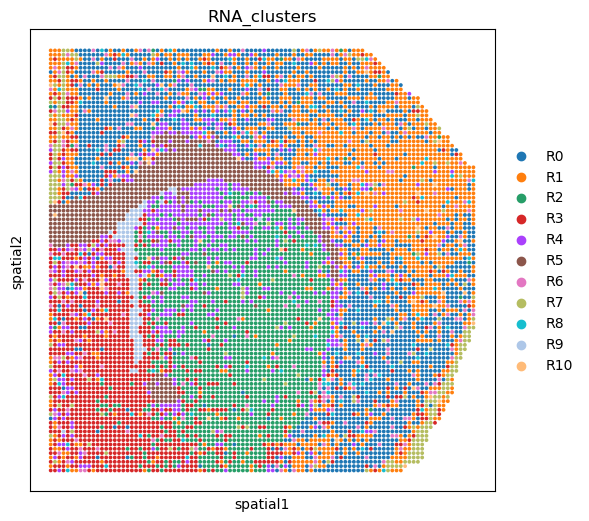

In [3]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

sc.pl.embedding(adata_RNA, basis='spatial', color='RNA_clusters', ax=ax, s=30)

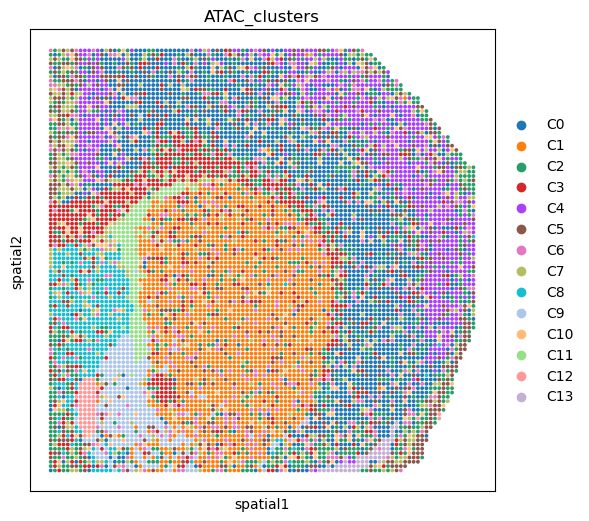

In [4]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

sc.pl.embedding(adata_ATAC, basis='spatial', color='ATAC_clusters', ax=ax, s=30)

### Preprocess

In [5]:
adata_RNA.var_names_make_unique()
adata_ATAC.var_names_make_unique()

In [6]:
sc.pp.filter_genes(adata_RNA, min_cells=10)
sc.pp.filter_cells(adata_RNA, min_genes=200)
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=3000)

In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable'] == True].copy()
sc.tl.pca(adata_RNA, n_comps =50)

In [8]:
def lsi(
        adata: anndata.AnnData, n_components: int = 20,
        use_highly_variable: Optional[bool] = None, **kwargs
       ) -> None:
    r"""
    LSI analysis (following the Seurat v3 approach)
    """
    if use_highly_variable is None:
        use_highly_variable = "highly_variable" in adata.var
    adata_use = adata[:, adata.var["highly_variable"]] if use_highly_variable else adata
    X = tfidf(adata_use.X)
    #X = adata_use.X
    X_norm = sklearn.preprocessing.Normalizer(norm="l1").fit_transform(X)
    X_norm = np.log1p(X_norm * 1e4)
    X_lsi = sklearn.utils.extmath.randomized_svd(X_norm, n_components, **kwargs)[0]
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    #adata.obsm["X_lsi"] = X_lsi
    adata.obsm["X_lsi"] = X_lsi[:,1:]

def tfidf(X):
    r"""
    TF-IDF normalization (following the Seurat v3 approach)
    """
    idf = X.shape[0] / X.sum(axis=0)
    if scipy.sparse.issparse(X):
        tf = X.multiply(1 / X.sum(axis=1))
        return tf.multiply(idf)
    else:
        tf = X / X.sum(axis=1, keepdims=True)
        return tf * idf

In [9]:
adata_ATAC.X = adata_ATAC.X.toarray()
if 'X_lsi' not in adata_ATAC.obsm.keys():
    sc.pp.highly_variable_genes(adata_ATAC, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata_ATAC, use_highly_variable=False, n_components=51)

In [10]:
adata_RNA.obsm['feat'] = adata_RNA.obsm['X_pca']
adata_ATAC.obsm['feat'] = adata_ATAC.obsm['X_lsi']

### Training of alignment model

In [11]:
Model = spcoral.model.regist_model(
    adata_omics1 = adata_RNA,
    adata_omics2 = adata_ATAC,
    graph_method = 'radius',
    n_layer=[1, 3, 5, 7, 9, 11, 13, 15],
    radius_spatial_omics1 = 1.5,
    radius_spatial_omics2 = 1.5,
    alpha = 0.1,
    epochs=200,
    random_seed=2030,
    device = torch.device('cuda:2')
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


In [12]:
adata_RNA, adata_ATAC, loss_list = Model.train()
adata_RNA, registering_parameters = spcoral.model.registration(
    adata_RNA, adata_ATAC, n_iter=10, beta=0.9, method='rigid'
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.26it/s]


The number of anchors is 5996


### Show the results of alignment model

<Axes: title={'center': 'SPCoral Alignment'}, xlabel='spatial1', ylabel='spatial2'>

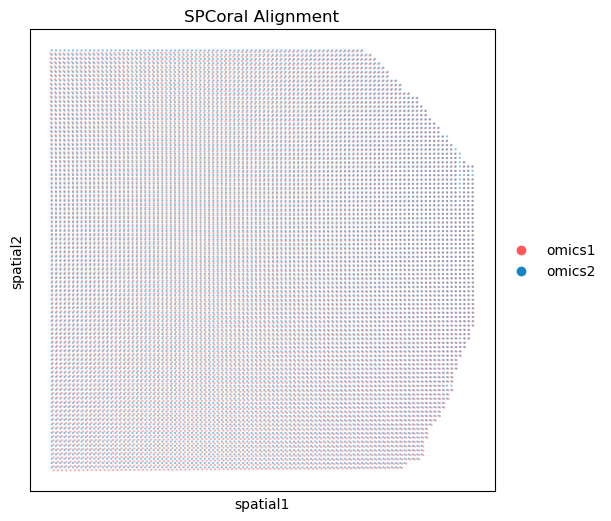

In [13]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

spcoral.plot.show_cross_align(
    adata_RNA, adata_ATAC,
    omics1_use_obsm='spatial_reg', 
    omics2_use_obsm='spatial',
    ax=ax,
    size_omics1=10,
    size_omics2=10,
    alpha_omics1=0.5,
    alpha_omics2=0.5,
    title='SPCoral Alignment',
    show=False
)

### Training of integration model

In [14]:
adata_RNA.obsm['spatial'] = adata_RNA.obsm['spatial_reg']

In [15]:
Model = spcoral.model.integrate_model(
    adata_RNA,
    adata_ATAC,
    graph_method_single='radius',
    radius_spatial_omics1=1.5,
    radius_spatial_omics2=1.5,
    use_obsm='spatial',
    device=torch.device('cuda:0'),
    k_cross_omics=4,
    k_all_omics=8,
    loss_weight=[1, 10, 1, 10, 1],
    random_seed=2020,
    g_all_auto=False
)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


In [16]:
adata_RNA, adata_ATAC, loss_list = Model.train()
adata_RNA, adata_ATAC = spcoral.analysis.cluster(adata_RNA, adata_ATAC, cluster_method='louvain', resolution_louvain=1.0)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:42<00:00,  1.34s/it]


### Show the spatial domain of clusting with the output of integration model

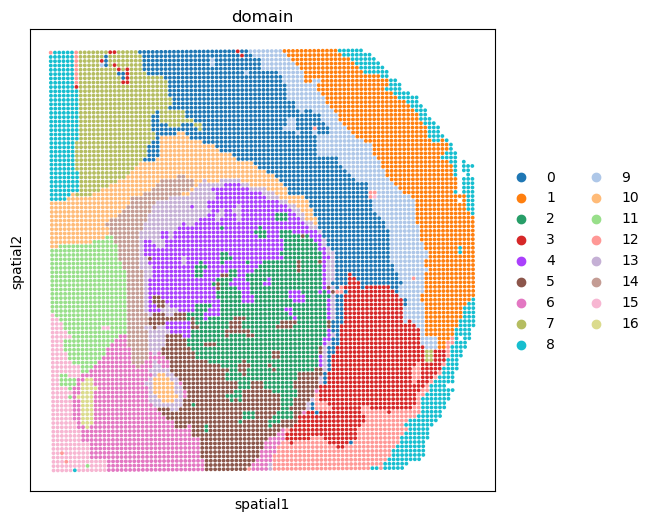

In [17]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

sc.pl.embedding(adata_RNA, basis='spatial', color='domain', ax=ax, s=30)

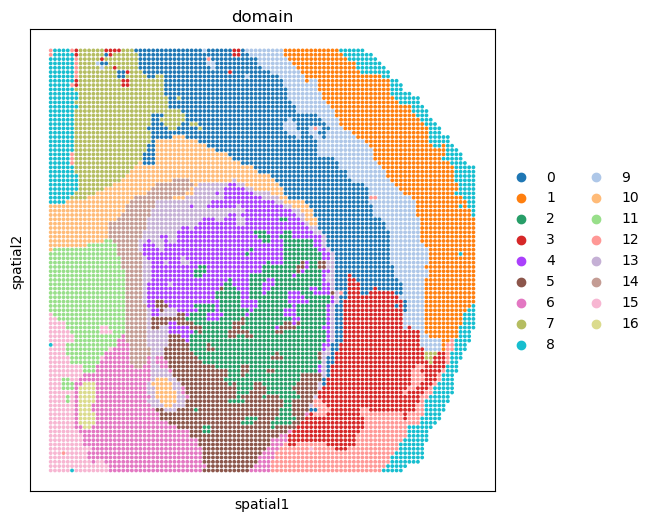

In [18]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

sc.pl.embedding(adata_ATAC, basis='spatial', color='domain', ax=ax, s=30)